In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import random

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
train_dir = "FruitinAmazon/train"
test_dir = "FruitinAmazon/test"

# Verify directory structure
class_names = sorted(os.listdir(train_dir))
print(f"Found {len(class_names)} classes: {class_names}")

# Check for corrupted images
corrupted_images = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, UnidentifiedImageError):
                corrupted_images.append(img_path)

print(f"\nFound {len(corrupted_images)} corrupted images" if corrupted_images else "\nNo corrupted images found")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']

No corrupted images found


In [ ]:
# Check class distribution
class_counts = {class_name: len([f for f in os.listdir(os.path.join(train_dir, class_name))
                if f.lower().endswith(('.png','.jpg','.jpeg'))])
                for class_name in class_names}

print("\nClass Distribution:")
print("="*40)
print(f"{'Class':<20}{'Count':>10}")
print("="*40)
for class_name, count in class_counts.items():
    print(f"{class_name:<20}{count:>10}")
print("="*40)


Class Distribution:
Class                    Count
acai                        15
cupuacu                     15
graviola                    15
guarana                     15
pupunha                     15
tucuma                      15


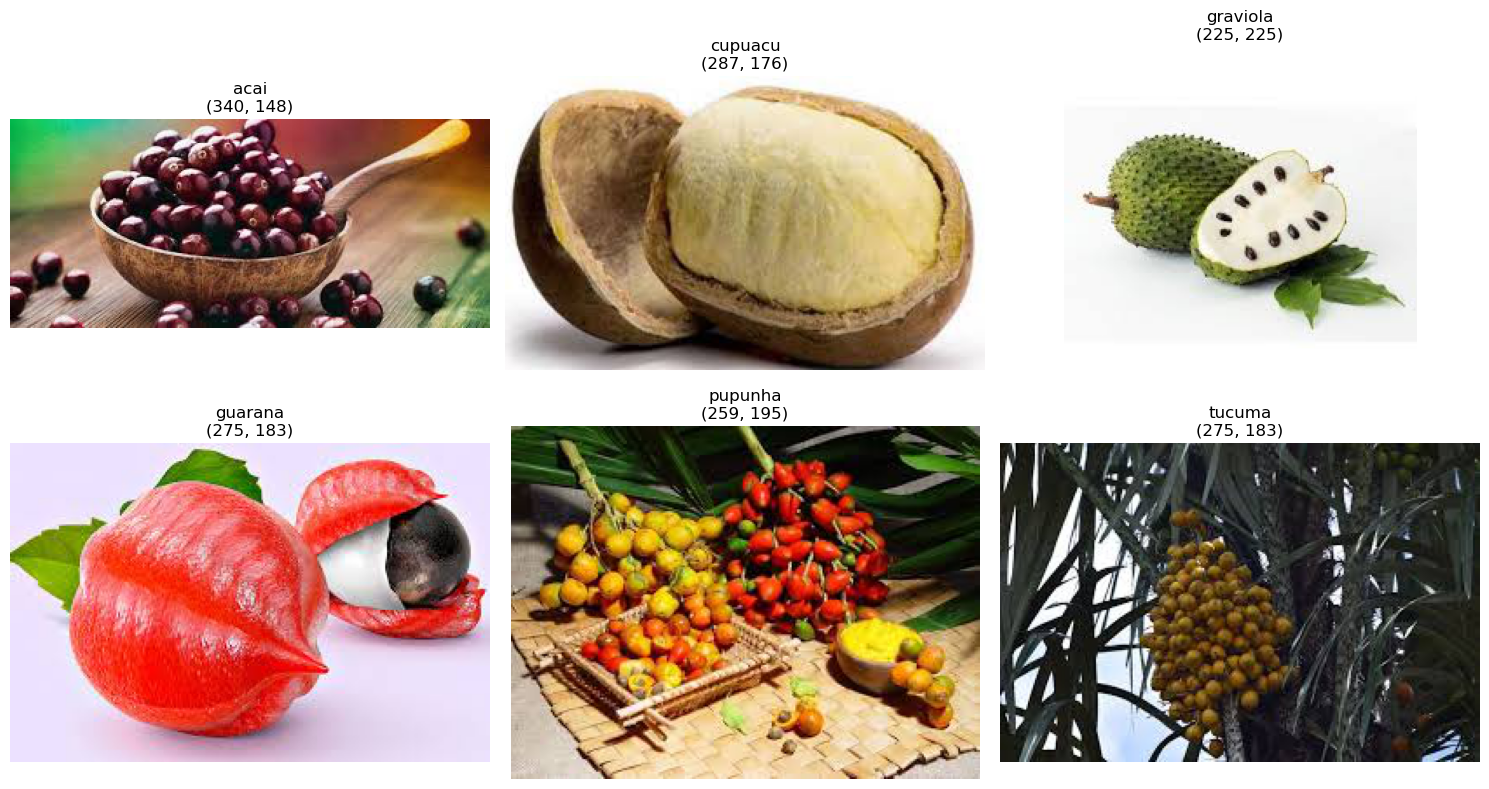

In [ ]:
# Visualize samples
plt.figure(figsize=(15,8))
for i, class_name in enumerate(class_names[:6]):
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    img_path = os.path.join(class_path, random.choice(images))
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"{class_name}\n{img.size}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#  2. Data Pipeline

image_size = (128, 128)
batch_size = 32

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


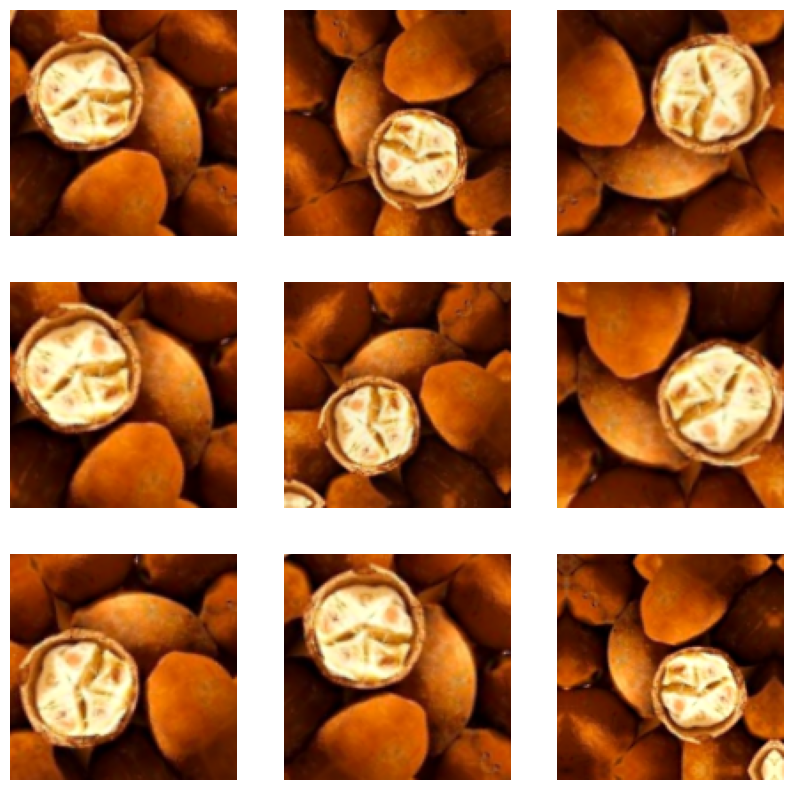

In [ ]:
# Configure performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

# Visualize augmented images
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [ ]:
# ## 3. Enhanced CNN Model

# %%
def create_fruit_cnn():
    model = keras.Sequential([
        # Input and preprocessing
        keras.Input(shape=(*image_size, 3)),
        data_augmentation,
        layers.Rescaling(1./255),

        # Conv Block 1
        layers.Conv2D(64, (3,3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 2
        layers.Conv2D(128, (3,3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(256, (3,3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 4
        layers.Conv2D(512, (3,3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        # Output
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

cnn_model = create_fruit_cnn()
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,556,934 (5.94 MB)

 Trainable params: 1,555,014 (5.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
#Training the CNN
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        min_delta=0.005
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Training
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.1871 - loss: 1.9603 - val_accuracy: 0.1667 - val_loss: 1.7430 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4983 - loss: 1.7060 - val_accuracy: 0.2222 - val_loss: 1.7787 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5642 - loss: 1.3628 - val_accuracy: 0.2222 - val_loss: 1.8642 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6723 - loss: 0.8038 - val_accuracy: 0.2222 - val_loss: 1.9800 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6732 - loss: 0.8320 - val_accuracy: 0.2222 - val_loss: 2.1903 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6762 - loss: 0.7583 - val_accuracy: 0.2222 - val_loss: 2.5455 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7483 - loss: 0.6120 - val_accuracy: 0.2222 - val_

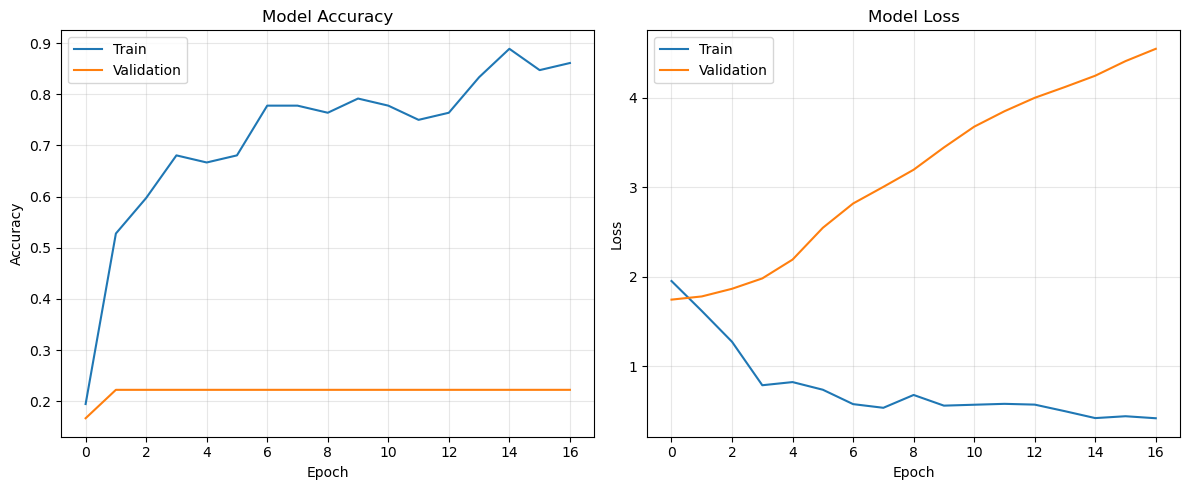

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_history(history)

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step - accuracy: 0.1667 - loss: 1.7773

Test Accuracy: 0.1667
Test Loss: 1.7773
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step

Classification Report:
              precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.17      1.00      0.29         5
    graviola       0.00      0.00      0.00         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.17        30
   macro avg       0.03      0.17      0.05        30
weighted avg       0.03      0.17      0.05        30



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


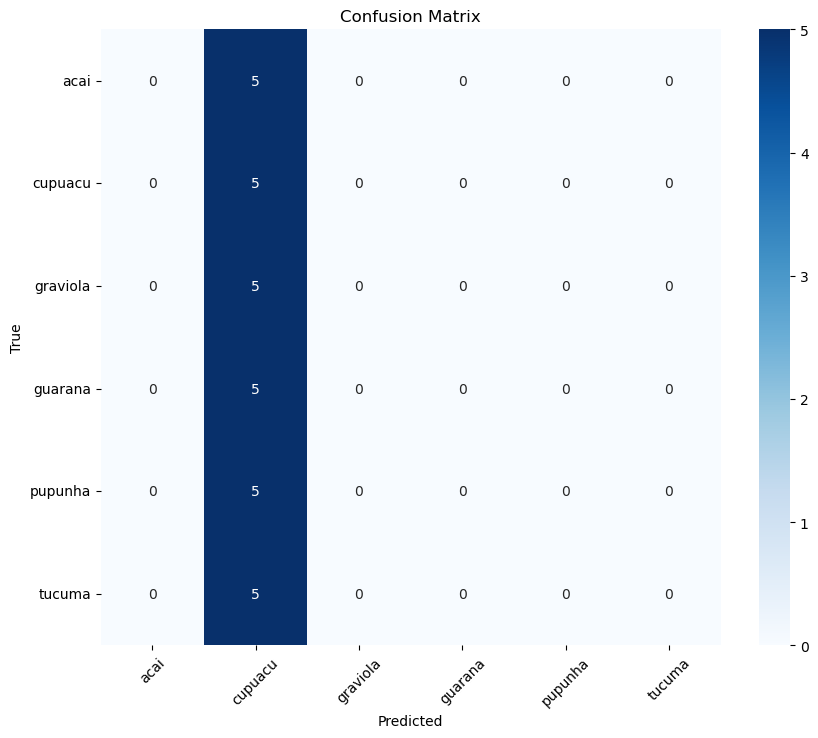

In [ ]:
# ### Evaluation

# %%
# Load test set
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size
)

# Evaluate
test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(cnn_model.predict(test_ds), axis=1)

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# ## 4. Transfer Learning with VGG16

# %%
# Load pre-trained VGG16
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(*image_size, 3)
)

# Freeze base model
base_model.trainable = False

# Build transfer model
inputs = keras.Input(shape=(*image_size, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

vgg_model = keras.Model(inputs, outputs)

# Compile
vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,422 (57.15 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train
vgg_history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1367 - loss: 15.4481 - val_accuracy: 0.1111 - val_loss: 8.3866
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1693 - loss: 11.8544 - val_accuracy: 0.1111 - val_loss: 7.8379
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1740 - loss: 12.3595 - val_accuracy: 0.1111 - val_loss: 7.3485
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1359 - loss: 10.7454 - val_accuracy: 0.1667 - val_loss: 6.8717
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2804 - loss: 9.6696 - val_accuracy: 0.2222 - val_loss: 6.4207
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2904 - loss: 9.4412 - val_accuracy: 0.2222 - val_loss: 6.0985
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3364 - loss: 9.1588 - val_accuracy: 0.2222 - val_loss: 5.8497
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3151 - loss: 10.1200 - val_accuracy: 0.2222 - val_loss: 5.5893
Epoch 9/

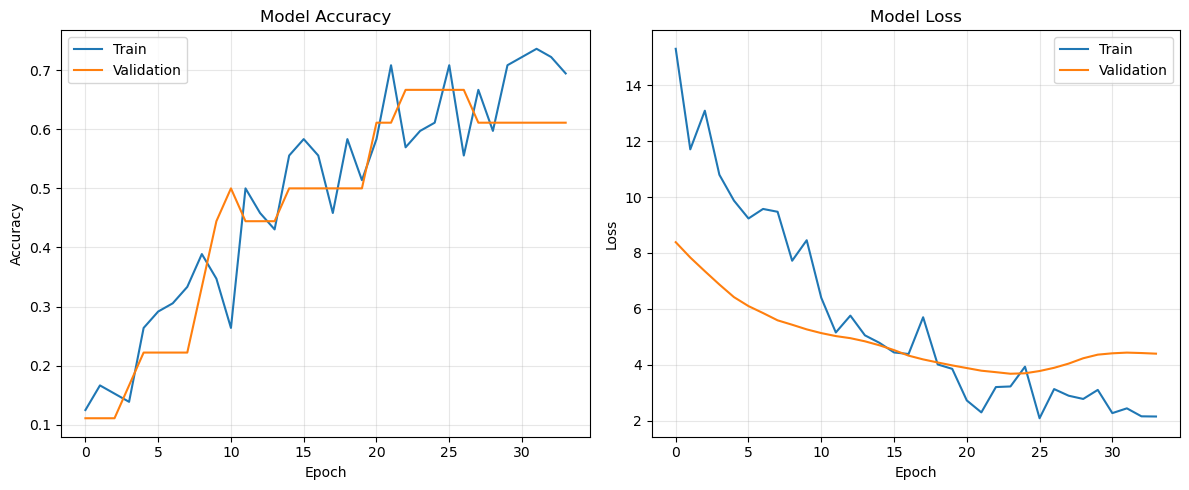

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5333 - loss: 4.5643

VGG16 Test Accuracy: 0.5333
VGG16 Test Loss: 4.5643


In [ ]:
# Evaluation
plot_history(vgg_history)

vgg_test_loss, vgg_test_acc = vgg_model.evaluate(test_ds)
print(f"\nVGG16 Test Accuracy: {vgg_test_acc:.4f}")
print(f"VGG16 Test Loss: {vgg_test_loss:.4f}")

In [ ]:
# Compare models
print("\nModel Comparison:")
print(f"CNN from scratch - Test Accuracy: {test_acc:.4f}")
print(f"VGG16 Transfer Learning - Test Accuracy: {vgg_test_acc:.4f}")


Model Comparison:
CNN from scratch - Test Accuracy: 0.1667
VGG16 Transfer Learning - Test Accuracy: 0.5333


In [ ]:
# Save models
cnn_model.save('fruits_cnn.h5')
vgg_model.save('fruits_vgg16.h5')